In [15]:
%load_ext autoreload
%autoreload 1
%aimport src
%aimport src.utils
%aimport src.SdmIsmAnalysis
%aimport src.SimpleSynthesis

# display last assigned variable automatically
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

%matplotlib inline
from matplotlib.pyplot import *

from src.utils import mygrid

import seaborn as sns
import polars as pl
import numpy as np
import scipy
from pathlib import Path
import os

from src.SimpleSynthesis import SimpleSynthesis

import pyfar as pf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Order the existing samples randomly but with training at first position (index 2):

In [16]:
good_ones_raw = pl.read_parquet("listening_test_good_ones.parquet").with_row_index()
with pl.Config(tbl_rows=100):
    display(good_ones_raw)

index,to_listener,to_source,room,from_listener,from_source,error_score
u32,str,i32,str,str,i32,f64
0,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",1,0.721165
1,"""-1.25X_0.0Y""",4,"""HL06W""","""3.0X_2.0Y""",1,0.713777
2,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",0,0.775207
3,"""1.75X_-2.0Y""",1,"""HL06W""","""3.0X_2.0Y""",4,0.605492
4,"""3.0X_2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,0.636626
5,"""-1.25X_0.0Y""",0,"""HL06W""","""1.75X_-2.0Y""",1,1.178172
6,"""1.75X_-2.0Y""",2,"""HL06W""","""3.0X_2.0Y""",0,1.0148
7,"""0.0X_0.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,0.454629
8,"""3.0X_2.0Y""",3,"""HL06W""","""3.0X_2.0Y""",2,0.55195


Have the two training examples at index 0 and 1, then the others randomly:

In [17]:
training0_idx = good_ones_raw.filter(
    pl.col("room").eq("HL05W") & pl.col("to_listener").eq("0.0X_0.0Y") & pl.col("to_source").eq(1)
)["index"][0]

7

In [18]:
training1_idx = good_ones_raw.filter(
    pl.col("room").eq("HL06W") & pl.col("to_listener").eq("3.0X_2.0Y") & pl.col("to_source").eq(4)
)["index"][0]

0

In [19]:
np.random.seed(497273)
order_permutation = np.concatenate(([training0_idx, training1_idx], np.random.permutation([i for i in range(20) if i not in [training0_idx, training1_idx]])))

array([ 7,  0,  9,  2, 12,  4, 17,  5, 10, 18,  8,  3,  1, 15, 14, 19,  6,
       13, 11, 16])

In [20]:
assert np.unique(order_permutation).size == good_ones_raw.shape[0]

In [21]:
good_ones = good_ones_raw[order_permutation].drop("index").with_row_index()

index,to_listener,to_source,room,from_listener,from_source,error_score
u32,str,i32,str,str,i32,f64
0,"""0.0X_0.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,0.454629
1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",1,0.721165
2,"""1.75X_-2.0Y""",2,"""HL05W""","""1.75X_-2.0Y""",0,0.397234
3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",0,0.775207
4,"""1.75X_-2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",0,0.642112
…,…,…,…,…,…,…
15,"""-1.25X_0.0Y""",3,"""HL06W""","""3.0X_2.0Y""",0,0.864433
16,"""1.75X_-2.0Y""",2,"""HL06W""","""3.0X_2.0Y""",0,1.0148
17,"""3.0X_2.0Y""",3,"""HL05W""","""0.0X_0.0Y""",3,0.652367


In [22]:
bad_ones = pl.read_parquet("listening_test_bad_ones.parquet")
with pl.Config(tbl_rows=100):
    display(bad_ones)

to_listener,to_source,room,from_listener,from_source,error_score
str,i32,str,str,i32,f64
"""3.0X_2.0Y""",1,"""HL06W""","""1.75X_-2.0Y""",3,2.235143
"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",3,1.754721
"""3.0X_2.0Y""",3,"""HL06W""","""3.0X_2.0Y""",4,1.447027
"""3.0X_2.0Y""",3,"""HL05W""","""1.75X_-2.0Y""",4,1.229486
"""1.75X_-2.0Y""",0,"""HL05W""","""3.0X_2.0Y""",2,1.560093
"""-1.25X_0.0Y""",3,"""HL05W""","""3.0X_2.0Y""",0,1.019636
"""-1.25X_0.0Y""",4,"""HL06W""","""1.75X_-2.0Y""",3,1.470415
"""1.75X_-2.0Y""",1,"""HL06W""","""1.75X_-2.0Y""",3,1.348235
"""3.0X_2.0Y""",1,"""HL05W""","""3.0X_2.0Y""",3,1.251613


In [23]:
df0 = good_ones.select(
    "index", "to_listener", "to_source", "room",
    pl.col("from_listener").alias("from_listener_good"),
    pl.col("from_source").alias("from_source_good"),
).join(
    bad_ones.select(
        "to_listener", "to_source", "room",
        pl.col("from_listener").alias("from_listener_bad"),
        pl.col("from_source").alias("from_source_bad"),
    ),
    ["room", "to_listener", "to_source", ],
).sort("index")
with pl.Config(tbl_rows=100):
    display(df0)

index,to_listener,to_source,room,from_listener_good,from_source_good,from_listener_bad,from_source_bad
u32,str,i32,str,str,i32,str,i32
0,"""0.0X_0.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,"""3.0X_2.0Y""",1
1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",1,"""3.0X_2.0Y""",3
2,"""1.75X_-2.0Y""",2,"""HL05W""","""1.75X_-2.0Y""",0,"""3.0X_2.0Y""",1
3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",0,"""3.0X_2.0Y""",3
4,"""1.75X_-2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",0,"""3.0X_2.0Y""",3
5,"""3.0X_2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,"""3.0X_2.0Y""",3
6,"""-1.75X_-3.0Y""",4,"""HL06W""","""3.0X_2.0Y""",4,"""0.0X_0.0Y""",2
7,"""-1.25X_0.0Y""",0,"""HL06W""","""1.75X_-2.0Y""",1,"""-1.75X_-3.0Y""",1
8,"""-1.75X_-3.0Y""",4,"""HL05W""","""3.0X_2.0Y""",0,"""0.0X_0.0Y""",3


# Join in Azimuths

In [24]:
listenting_test_azimuths = np.array([ # determined approximately by hand
    -60,
    -30,
    90,
    -120,
    -60,
    0,
    -90, # adjusted from -90
    120,
    60,
    0,
    -150
])

listening_test_positions = np.array([
    "-1.25X_0.0Y_3SRC", # used to be "3.0X_2.0Y_0SRC" and ">0.0X_0.0Y_3SRC", but T30 not available
    "1.75X_-2.0Y_2SRC",
    "-1.75X_-3.0Y_4SRC",
    "3.0X_2.0Y_1SRC",
    "-1.25X_0.0Y_4SRC",
    "-1.25X_0.0Y_0SRC",
    "3.0X_2.0Y_3SRC",
    "1.75X_-2.0Y_0SRC",
    "1.75X_-2.0Y_1SRC", # used to be what training is
    "0.0X_0.0Y_1SRC", # training, T30 only in HL05W valid
    "3.0X_2.0Y_4SRC", #training, pick only from HL06W
])

original_az = pl.DataFrame({"az":np.arange(-180, 180, 30)}).with_row_index("az_idx")

az_idx,az
u32,i32
0,-180
1,-150
2,-120
3,-90
4,-60
…,…
7,30
8,60
9,90


In [25]:
az_df = pl.DataFrame({
    "az":listenting_test_azimuths, 
    "to":listening_test_positions
}).join(original_az, "az")

az,to,az_idx
i32,str,u32
-150,"""3.0X_2.0Y_4SRC…",1
-120,"""3.0X_2.0Y_1SRC…",2
-90,"""3.0X_2.0Y_3SRC…",3
-60,"""-1.25X_0.0Y_3S…",4
-60,"""-1.25X_0.0Y_4S…",4
…,…,…
0,"""-1.25X_0.0Y_0S…",6
0,"""0.0X_0.0Y_1SRC…",6
60,"""1.75X_-2.0Y_1S…",8


In [26]:
df = df0.with_columns(
    to = pl.concat_str([
        pl.col("to_listener"),
        pl.lit("_"),
        pl.col("to_source"),
        pl.lit("SRC")
    ])
).join(
    az_df, 
    "to"
).select(pl.exclude(
    "to"
))
with pl.Config(tbl_rows=100):
    display(df)

index,to_listener,to_source,room,from_listener_good,from_source_good,from_listener_bad,from_source_bad,az,az_idx
u32,str,i32,str,str,i32,str,i32,i32,u32
0,"""0.0X_0.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,"""3.0X_2.0Y""",1,0,6
1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",1,"""3.0X_2.0Y""",3,-150,1
2,"""1.75X_-2.0Y""",2,"""HL05W""","""1.75X_-2.0Y""",0,"""3.0X_2.0Y""",1,-30,5
3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",0,"""3.0X_2.0Y""",3,120,10
4,"""1.75X_-2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",0,"""3.0X_2.0Y""",3,60,8
5,"""3.0X_2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,"""3.0X_2.0Y""",3,-120,2
6,"""-1.75X_-3.0Y""",4,"""HL06W""","""3.0X_2.0Y""",4,"""0.0X_0.0Y""",2,90,9
7,"""-1.25X_0.0Y""",0,"""HL06W""","""1.75X_-2.0Y""",1,"""-1.75X_-3.0Y""",1,0,6
8,"""-1.75X_-3.0Y""",4,"""HL05W""","""3.0X_2.0Y""",0,"""0.0X_0.0Y""",3,90,9


In [27]:
df.write_parquet("listening_test_design.parquet")

# Design FIR Lowpass for MUSHRA

The characteristics of the 3.5 kHz low-pass filter should be as follows:

fc = 3.5 kHz

Maximum pass band ripple = +-0.1 dB

Minimum attenuation at 4 kHz = 25 dB

Minimum attenuation at 4.5 kHz = 50 dB

I chose 7 kHz, since otherwise the spectral distortion is too large!

In [28]:
N_lp = 265
fc = 1.015*7e3 # Hz # increased a bit to approx. hit -3 dB at fc
fs = 48e3

48000.0

In [29]:
lp = scipy.signal.firwin(N_lp, fc, fs=fs, )

array([-4.64918606e-05,  1.23380326e-04,  1.96887693e-04,  1.12219568e-04,
       -6.71075248e-05, -1.98927707e-04, -1.73508791e-04, -3.59737503e-06,
        1.79433035e-04,  2.25492389e-04,  8.71933391e-05, -1.34120295e-04,
       -2.60741255e-04, -1.79423329e-04,  5.94016174e-05,  2.69468561e-04,
        2.71906109e-04,  4.54600398e-05, -2.40885900e-04, -3.51560499e-04,
       -1.76059698e-04,  1.65632734e-04,  4.01296017e-04,  3.21067443e-04,
       -3.89031515e-05, -4.02163197e-04, -4.61600011e-04, -1.36359222e-04,
        3.36835944e-04,  5.72247760e-04,  3.46977007e-04, -1.93955901e-04,
       -6.23978449e-04, -5.68546668e-04, -2.74264169e-05,  5.88766544e-04,
        7.66554835e-04,  3.14260546e-04, -4.45394665e-04, -8.99900925e-04,
       -6.37718802e-04,  1.85518128e-04,  9.26691921e-04,  9.54023665e-04,
        1.81150373e-04, -8.11699223e-04, -1.20831591e-03, -6.23730321e-04,
        5.34431635e-04,  1.34150556e-03,  1.09016697e-03, -9.64683870e-05,
       -1.29948659e-03, -

In [30]:
lp_sig = pf.Signal(lp, sampling_rate=fs)

time domain energy Signal:
(1,) channels with 265 samples @ 48000.0 Hz sampling rate and none FFT normalization

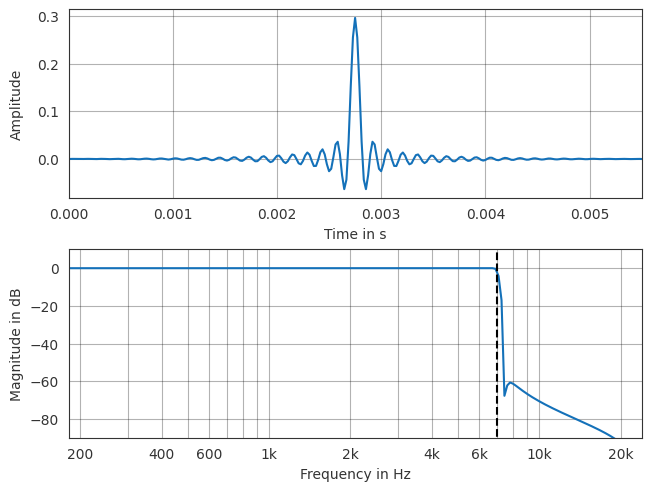

In [31]:
pf.plot.time_freq(lp_sig)
axvline(7e3, -1, 1, color="black", linestyle="--")

(-0.4, 0.4)

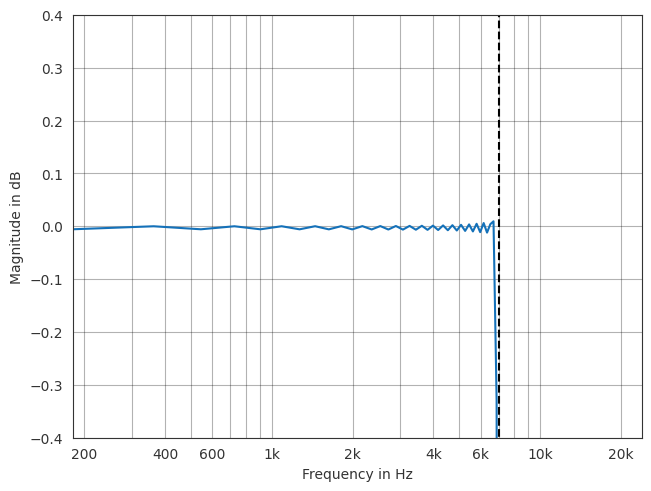

In [32]:
pf.plot.freq(lp_sig)
axvline(7e3, -1, 1, color="black", linestyle="--")
ylim(-.4, .4)

(5000.0, 10000.0)

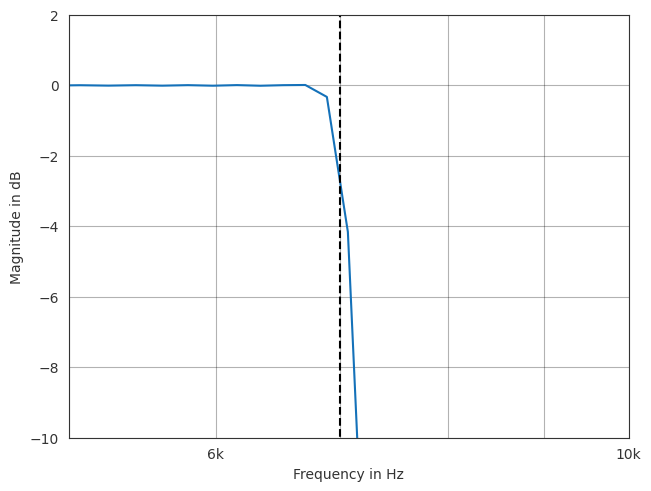

In [33]:
pf.plot.freq(lp_sig)
axvline(7e3, -1, 1, color="black", linestyle="--")
ylim(-10, 2)
xlim(5e3, 10e3)

In [34]:
lp_delay = np.argmax(lp_sig.time)

132

# Render BRIRs

In [35]:
main_path = Path("../data/processed/analysis_e10_full_run2")

a = (
    SimpleSynthesis()
    .read_HRTFs(
        "../data/processed/RWTH-2020-11307/Kemar_HRTF_sofa-onax_normalized.sofa"
    )
    .read_source_fr("../data/external/RL906-spatial-FR.sofa")
)

b = (
    SimpleSynthesis()
    .read_HRTFs(
        "../data/processed/RWTH-2020-11307/Kemar_HRTF_sofa-onax_normalized.sofa"
    )
    .read_source_fr("../data/external/RL906-spatial-FR.sofa")
)

SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription


C:\Users\jcmfs\Documents\MA\e4-vis-dataset\.venv\Lib\site-packages\pyfar\classes\coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((


SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription


In [36]:
arr = []
for row in df.iter_rows(named=True):
    to_name = f'{row["room"]}_{row["to_listener"]}_{row["to_source"]}SRC'
    print(f'{row["index"]} {to_name}')
    
    # reference
    a.read_input_sofas(main_path / to_name)
    reference_brir = a.reference_brirs[row["az_idx"], :]

    # bad extrapolation
    from_name = f'{row["room"]}_{row["from_listener_bad"]}_{row["from_source_bad"]}SRC'
    print(f'{row["index"]} {from_name}')
    b.read_input_sofas(main_path / from_name)
    bad_extrapolation = b.extrapolating_synthesis(
        a.source_position, 
        a.source_orientation, 
        a.listener_position,
        only_brir_indices=[row["az_idx"]]
    )[row["az_idx"], :]

    # bad extrapolation with exclusion
    bad_runs = pl.read_parquet(main_path / from_name / "runs.parquet").with_row_index()
    bad_filtered_imsrcs = bad_runs.filter(pl.col("filter_energy") >= 5.5)["index"].to_list()
    print(f"filtered runs from bad: {bad_filtered_imsrcs} | src: {bad_runs[bad_filtered_imsrcs]['src'].to_list()}")
    bad_filtered = b.extrapolating_synthesis(
        a.source_position, 
        a.source_orientation, 
        a.listener_position, 
        imsrcs_make_unextrapolated=bad_filtered_imsrcs,
        only_brir_indices=[row["az_idx"]] 
    )[row["az_idx"], :]

    # mid anchor: bad one, only DS extrapolated, rest as if not extrapolating
    mid_anchor = b.extrapolating_synthesis(
        a.source_position, 
        a.source_orientation, 
        a.listener_position, 
        imsrcs_make_unextrapolated=list(range(1, len(b.ism_histories))), # all except 0 (direct sound)
        only_brir_indices=[row["az_idx"]] 
    )[row["az_idx"], :]

    # lower anchor: Offset by 90 degrees, lowpass 3.5/7k (?), leave out early reflections
    lower_anchor_az_idx = (row["az_idx"] + 3) % 12 # number of azimuths
    lower_anchor_no_lp = b.extrapolating_synthesis(
        a.source_position, 
        a.source_orientation, 
        a.listener_position, 
        ignore_imsrcs=list(range(1, len(b.ism_histories))), # ignore all except 0 (direct sound)
        only_brir_indices=[lower_anchor_az_idx] 
    )[lower_anchor_az_idx, :]
    lower_anchor = pf.dsp.convolve(lp_sig, lower_anchor_no_lp)[:, lp_delay:lp_delay+lower_anchor_no_lp.n_samples]
    
    arr.append({
        "reference": reference_brir,
        "lower_anchor": lower_anchor,
        "mid_anchor": mid_anchor,
        "bad": bad_extrapolation,
        "bad_filtered": bad_filtered,
    })

0 HL05W_0.0X_0.0Y_1SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound
0 HL05W_3.0X_2.0Y_1SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound
filtered runs from bad: [18] | src: [99]
1 HL06W_3.0X_2.0Y_4SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound
1 HL06W_3.0X_2.0Y_3SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound
filtered runs from bad: [3, 4, 6, 9, 12, 14, 15] | src: [13, 52, 71, 138, 247, 280, 301]
2 HL05W_1.75X_-2.0Y_2SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription,

In [37]:
brirs_df = pl.DataFrame(arr);
reference_energies = [np.mean(pf.dsp.energy(b)) for b in brirs_df["reference"]]

[0.005652016128491689,
 0.0014189212079641221,
 0.00723906293939702,
 0.001693414442152302,
 0.003171808518146666,
 0.00207996625480405,
 0.013149426947786981,
 0.0010673744637460965,
 0.01862501595621907,
 0.0026775287899545664,
 0.002320596168197289,
 0.002009149805326007,
 0.0026488304898137425,
 0.0019237811420378715,
 0.005109616065390843,
 0.004877733889608599,
 0.005087562136261017,
 0.0045174883903353474,
 0.0032365031260882674,
 0.003107150292486321]

There's a large variation in reference nergy. Normalize Energy Mean of Reference:

In [38]:
reference_target_level = -18 # dBFS
reference_target_energy = 10**(reference_target_level/10)

0.015848931924611134

In [39]:
arr2 = []
for i in range(len(arr)):
    d = arr[i]
    ref_energy = np.mean(pf.dsp.energy(
        d["reference"]
    ))
    print(ref_energy)
    ref_energy_to_target = ref_energy / reference_target_energy
    #print(ref_energy_to_target)
    d2 = {}
    for key in list(d.keys()):
        d2[key] = d[key] / np.sqrt(ref_energy_to_target)
    arr2.append(d2)

0.005652016128491689
0.0014189212079641221
0.00723906293939702
0.001693414442152302
0.003171808518146666
0.00207996625480405
0.013149426947786981
0.0010673744637460965
0.01862501595621907
0.0026775287899545664
0.002320596168197289
0.002009149805326007
0.0026488304898137425
0.0019237811420378715
0.005109616065390843
0.004877733889608599
0.005087562136261017
0.0045174883903353474
0.0032365031260882674
0.003107150292486321


In [40]:
[np.mean(pf.dsp.energy(arr2[i]["reference"])) for i in range(20)]

[0.015848931924611138,
 0.015848931924611127,
 0.015848931924611127,
 0.01584893192461113,
 0.015848931924611134,
 0.015848931924611127,
 0.01584893192461113,
 0.01584893192461113,
 0.015848931924611124,
 0.015848931924611134,
 0.015848931924611127,
 0.015848931924611127,
 0.015848931924611134,
 0.01584893192461113,
 0.015848931924611124,
 0.015848931924611127,
 0.015848931924611138,
 0.01584893192461113,
 0.015848931924611127,
 0.015848931924611124]

## Save out BRIRs

TODO maybe save the BRIRs later for analysis, e.g. to compare objective similarity scores with heard ones

In [45]:
conditions = list(arr2[0].keys())

['reference', 'lower_anchor', 'mid_anchor', 'bad', 'bad_filtered']

In [47]:
# convert to numpy n-D array, then save condition keys in comment as stringified list
brir_ndarray = np.zeros((20, 5, 2, 57600)) # dimensions: trial, condition, LR, time
conditions
for i in range(len(arr2)):
    d = arr2[i]
    assert list(d.keys()) == conditions
    for (j, key) in enumerate(conditions):
        brir_ndarray[i, j, :, :] = d[key].time

In [48]:
brir_ndarray_sig = pf.Signal(brir_ndarray, sampling_rate=arr2[0]["reference"].sampling_rate)

time domain energy Signal:
(20, 5, 2) channels with 57600 samples @ 48000.0 Hz sampling rate and none FFT normalization

In [50]:
pf.io.write("listening_test_brirs.pyfar", brirs=brir_ndarray_sig)

# Render with different Sounds

In [93]:
sound_paths = [Path("../src/data/listening_test_audio/processed/") / f for f in ["6_3.wav", "10_4.wav"]]

[WindowsPath('../src/data/listening_test_audio/processed/6_3.wav'),
 WindowsPath('../src/data/listening_test_audio/processed/10_4.wav')]

In [94]:
sounds = [pf.io.read_audio(sound_path) for sound_path in sound_paths]

[time domain energy Signal:
 (1,) channels with 142938 samples @ 48000 Hz sampling rate and none FFT normalization,
 time domain energy Signal:
 (1,) channels with 164698 samples @ 48000 Hz sampling rate and none FFT normalization]

In [95]:
rendered = []
for i in range(len(arr2)):
    d = arr2[i]
    sound = sounds[i % 2]
    
    d2 = {}
    for key in list(d.keys()):
        d2[key] = pf.dsp.convolve(d[key], sound)
    rendered.append(d2)

In [96]:
peaks = []
for i in range(len(rendered)):
    d = rendered[i]
    for key in list(d.keys()):
        peaks.append(np.max(np.abs(d[key].time)))
peak_max = np.max(peaks)

0.3993155641595324

In [97]:
peak_target = .9

0.9

In [98]:
peak_factor = peak_target/peak_max

2.2538565505060975

In [99]:
for i in range(len(rendered)):
    d = rendered[i]
    for key in list(d.keys()):
        pass
        #pf.plot.time(d[key], dB=True)

In [100]:
# Assume arr is your boolean NumPy array
arr = np.array([False, True, False, True, True, False])

# Find the highest index that is True
highest_index = np.where(arr)[0][-1]


4

In [101]:
np.where(arr)

(array([1, 3, 4], dtype=int64),)

In [102]:
(np.abs(rendered[0]["reference"].time) > .001)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [103]:
np.nonzero((np.abs(rendered[0]["reference"].time[0,:]) > .001))[0][-1]

153701

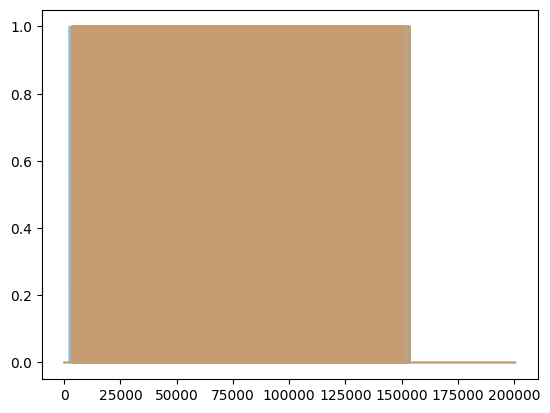

In [104]:
plot((np.abs(rendered[0]["reference"].time) > .001).T, alpha=.5)

In [105]:
np.abs(rendered[0]["reference"].time) > .0001

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [106]:
earliest_onset = rendered[0]["reference"].n_samples
latest_stop = 0
for i in range(len(rendered)):
    d = rendered[i]
    for key in list(d.keys()):
        mx = np.max(np.abs(d[key].time))
        threshold = mx * 10**(-60/20)
        onset = np.min(np.argmax(np.abs(d[key].time) > threshold, axis=1))
        if earliest_onset > onset:
            earliest_onset = onset
        left_stop = np.nonzero((np.abs(d[key].time[0,:]) > .001))[0][-1]
        right_stop = np.nonzero((np.abs(d[key].time[1,:]) > .001))[0][-1]
        stop = max(left_stop, right_stop)
        if stop > latest_stop:
            latest_stop = stop
(earliest_onset, latest_stop)

(1436, 178958)

In [107]:
pf.io.audio_formats()

{'AIFF': 'AIFF (Apple/SGI)',
 'AU': 'AU (Sun/NeXT)',
 'AVR': 'AVR (Audio Visual Research)',
 'CAF': 'CAF (Apple Core Audio File)',
 'FLAC': 'FLAC (Free Lossless Audio Codec)',
 'HTK': 'HTK (HMM Tool Kit)',
 'SVX': 'IFF (Amiga IFF/SVX8/SV16)',
 'MAT4': 'MAT4 (GNU Octave 2.0 / Matlab 4.2)',
 'MAT5': 'MAT5 (GNU Octave 2.1 / Matlab 5.0)',
 'MPC2K': 'MPC (Akai MPC 2k)',
 'MP3': 'MPEG-1/2 Audio',
 'OGG': 'OGG (OGG Container format)',
 'PAF': 'PAF (Ensoniq PARIS)',
 'PVF': 'PVF (Portable Voice Format)',
 'RAW': 'RAW (header-less)',
 'RF64': 'RF64 (RIFF 64)',
 'SD2': 'SD2 (Sound Designer II)',
 'SDS': 'SDS (Midi Sample Dump Standard)',
 'IRCAM': 'SF (Berkeley/IRCAM/CARL)',
 'VOC': 'VOC (Creative Labs)',
 'W64': 'W64 (SoundFoundry WAVE 64)',
 'WAV': 'WAV (Microsoft)',
 'NIST': 'WAV (NIST Sphere)',
 'WAVEX': 'WAVEX (Microsoft)',
 'WVE': 'WVE (Psion Series 3)',
 'XI': 'XI (FastTracker 2)'}

In [108]:
pf.io.audio_subtypes("WAV")

{'PCM_16': 'Signed 16 bit PCM',
 'PCM_24': 'Signed 24 bit PCM',
 'PCM_32': 'Signed 32 bit PCM',
 'PCM_U8': 'Unsigned 8 bit PCM',
 'FLOAT': '32 bit float',
 'DOUBLE': '64 bit float',
 'ULAW': 'U-Law',
 'ALAW': 'A-Law',
 'IMA_ADPCM': 'IMA ADPCM',
 'MS_ADPCM': 'Microsoft ADPCM',
 'GSM610': 'GSM 6.10',
 'G721_32': '32kbs G721 ADPCM',
 'NMS_ADPCM_16': '16kbs NMS ADPCM',
 'NMS_ADPCM_24': '24kbs NMS ADPCM',
 'NMS_ADPCM_32': '32kbs NMS ADPCM',
 'MPEG_LAYER_III': 'MPEG Layer III'}

In [109]:
pf.io.default_audio_subtype("WAV")

'PCM_16'

In [110]:
out_path = Path("../webMUSHRA-1.4.3/audio2")

if not os.path.exists(out_path):
    os.makedirs(out_path)

for i in range(len(rendered)):
    d = rendered[i]
    for key in list(d.keys()):
        filepath = out_path / f"{i:02}-{key}.wav"
        #print(filepath)
        cut = pf.dsp.time_window(d[key], (earliest_onset-480, earliest_onset, latest_stop, latest_stop+480), crop="window")
        pf.io.write_audio(peak_factor*cut, filepath, subtype="PCM_24")

# i = 0

In [85]:
i = 0
df[i]

index,to_listener,to_source,room,from_listener_good,from_source_good,from_listener_bad,from_source_bad,az,az_idx
u32,str,i32,str,str,i32,str,i32,i32,u32
0,"""0.0X_0.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,"""3.0X_2.0Y""",1,0,6


array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

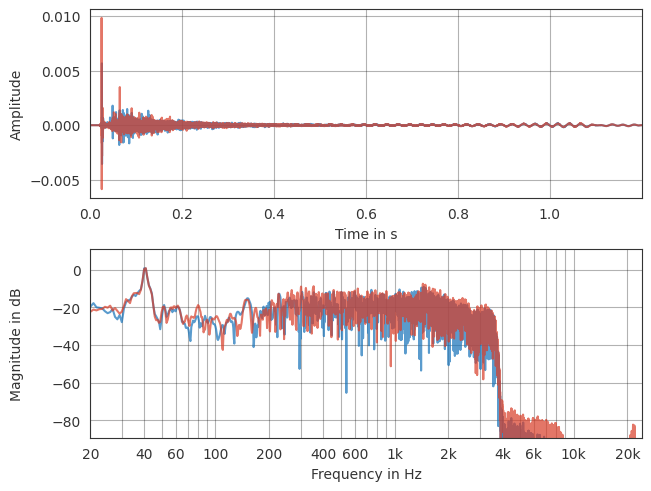

In [86]:
axs = pf.plot.time_freq(arr[i]["lower_anchor"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

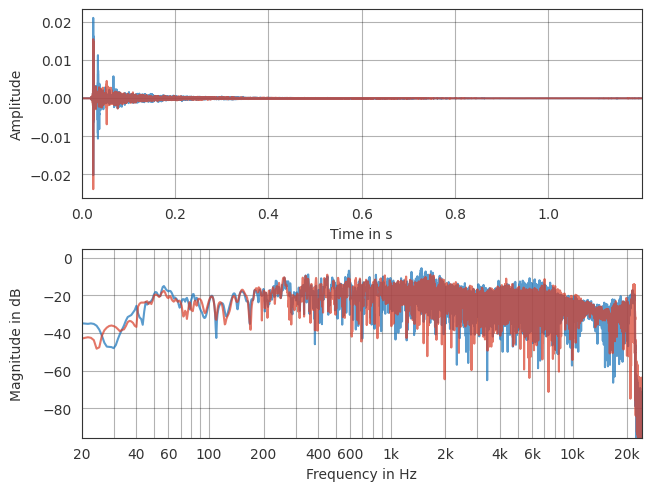

In [87]:
pf.plot.time_freq(arr[i]["reference"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

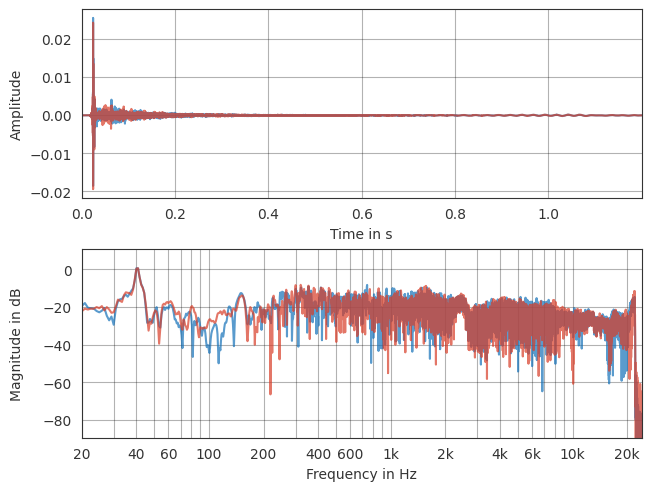

In [90]:
pf.plot.time_freq(arr[i]["mid_anchor"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

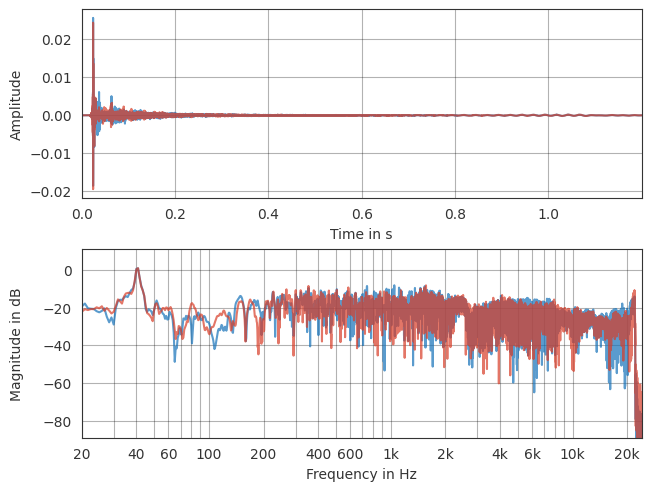

In [91]:
pf.plot.time_freq(arr[i]["bad"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

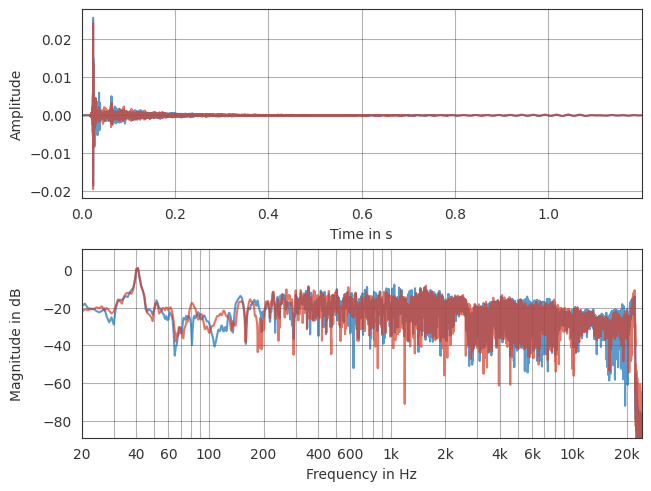

In [92]:
pf.plot.time_freq(arr[i]["bad_filtered"], alpha=.7)

(0.0, 0.1)

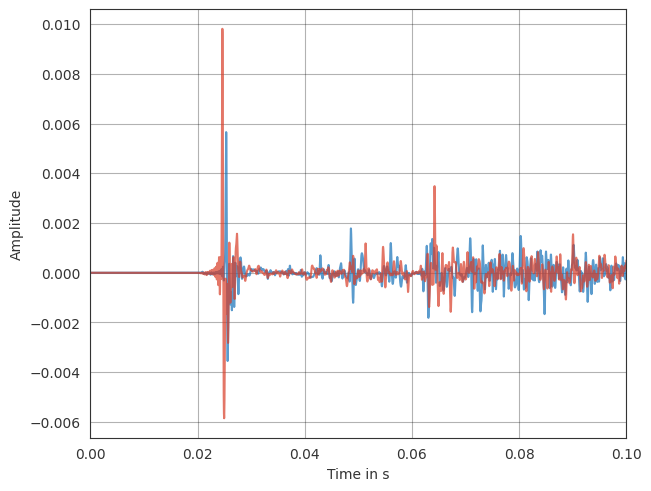

In [93]:
pf.plot.time(arr[i]["lower_anchor"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

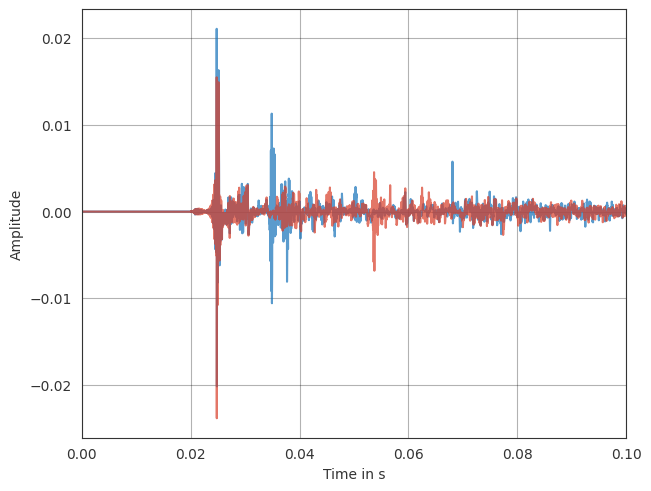

In [94]:
pf.plot.time(arr[i]["reference"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

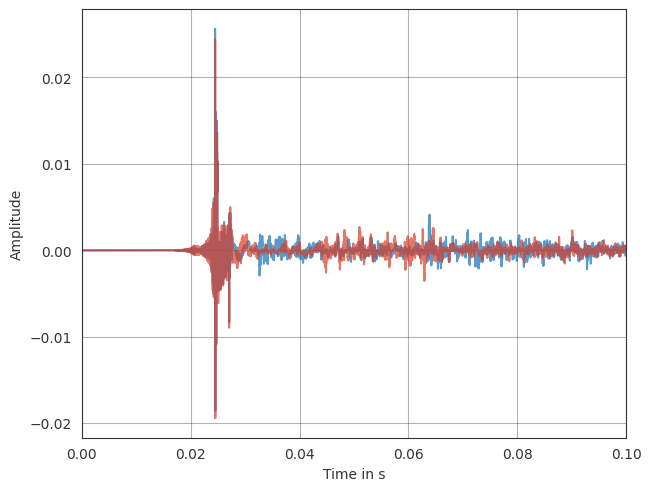

In [96]:
pf.plot.time(arr[i]["mid_anchor"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

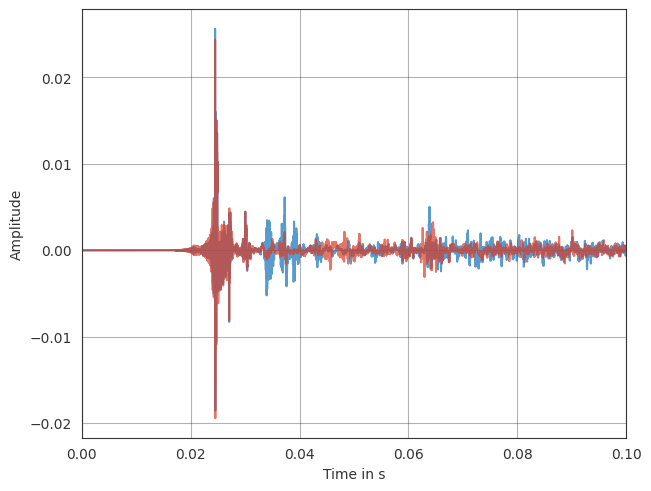

In [97]:
pf.plot.time(arr[i]["bad"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

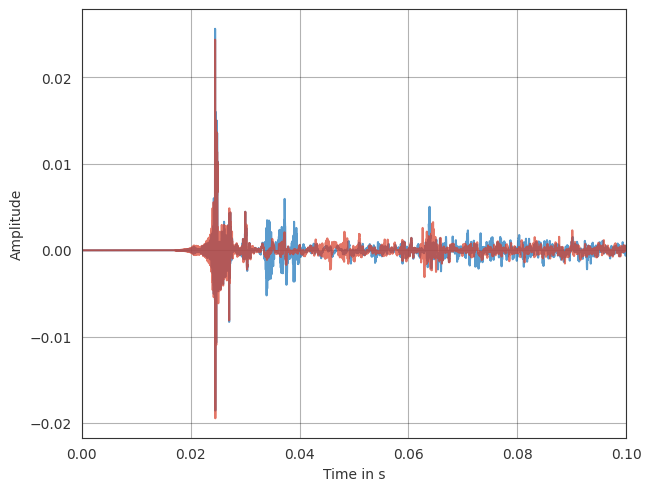

In [98]:
pf.plot.time(arr[i]["bad_filtered"], alpha=.7)
xlim(0, .1)